In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
import numpy as np

plt.style.use('ggplot')
seed = 101 # Lucky seed
np.random.seed(seed)

Define the target function. Although it's a simple function, we should assume that it's a black box we can't look into.

In [2]:
def target(x):
    return x*np.sin(x)

In [3]:
x = np.linspace(-2, 10, 100).reshape(-1,1)
y = target(x)

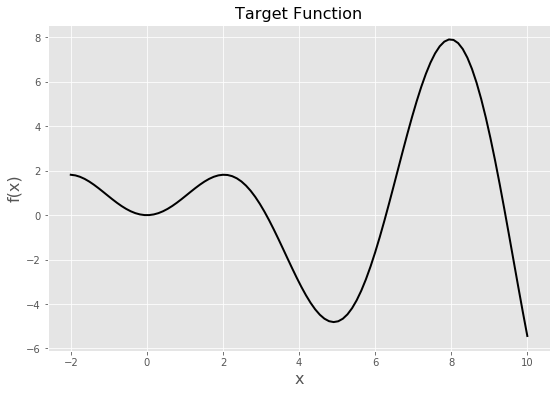

In [4]:
plt.figure(figsize=(9,6))
plt.plot(x, y, color='black', lw=2, label='Target')
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)
plt.title('Target Function', fontsize=16)
plt.show()

Draw some random samples and train a Gaussian Process Regressor on them.

In [5]:
x_sample = np.random.uniform(-2, 10, size=5).reshape(-1,1)
y_sample = target(x_sample)

gp = GaussianProcessRegressor(random_state=seed).fit(x_sample, y_sample)

Upper Confidence Bound (UCB)

In [6]:
def calc_ucb(mu, std, kappa):
    return mu + kappa*std.reshape(-1,1)

def plot_gp_ucb(gp, x, y):
    x_sample, y_sample = gp.X_train_, gp.y_train_
    
    plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, std = gp.predict(x, return_std=True)
    axis.plot(x, y, color='black', label='Target')
    axis.plot(x, mu, color='steelblue', label='Prediction')
    axis.fill_between(x.ravel(), mu.ravel()-1.96*std, mu.ravel()+1.96*std, color='steelblue', alpha=0.5, label='95% Confidence Interval')
    axis.scatter(x_sample, y_sample, color='tomato', label='Samples', zorder=15)
    axis.set_ylabel('$xsin(x)$')
    axis.set_title('Gaussian Process Regression and UCB @ 5 Samples', fontsize=16)
    
    for kappa in [1, 2, 5, 10]:
        util = calc_ucb(mu, std, kappa)
        acq.plot(x, util, label='$\kappa=%d$' % kappa)
        acq.scatter(x[util.argmax()], util.max())
        if kappa==5:
            axis.scatter(x[util.argmax()], mu[util.argmax()], marker='*', s=100, lw=1, color='gold', zorder=20, label='Next Guess')
    acq.set_title('UCB', fontsize=16)
    acq.set_xlabel('$x$')
    acq.set_ylabel('$Utility$')
    axis.legend(loc='best')
    acq.legend(loc='lower right')
    plt.show()

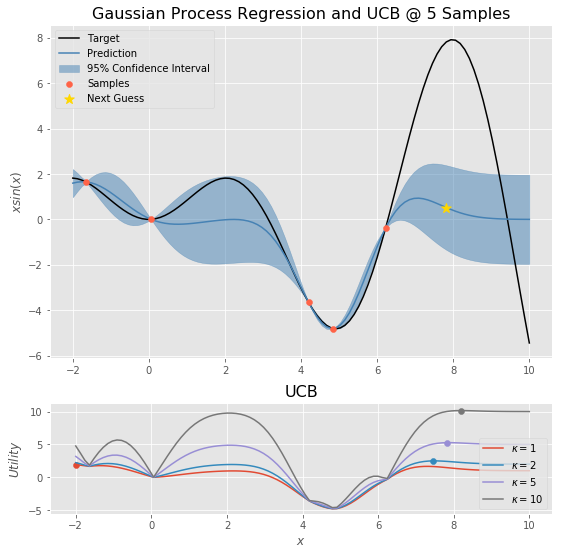

In [7]:
plot_gp_ucb(gp, x, y)

Probability of Improvement (PI)

In [8]:
def calc_pi(mu, std, y_max, xi):
    return norm.cdf((mu - y_max - xi)/std.reshape(-1,1))

def plot_gp_pi(gp, x, y):
    x_sample, y_sample = gp.X_train_, gp.y_train_
    
    plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, std = gp.predict(x, return_std=True)
    axis.plot(x, y, color='black', label='Target')
    axis.plot(x, mu, color='steelblue', label='Prediction')
    axis.fill_between(x.ravel(), mu.ravel()-1.96*std, mu.ravel()+1.96*std, color='steelblue', alpha=0.5, label='95% Confidence Interval')
    axis.scatter(x_sample, y_sample, color='tomato', label='Samples', zorder=15)
    axis.set_ylabel('$xsin(x)$')
    axis.set_title('Gaussian Process Regression and PI @ 5 Samples', fontsize=16)
    
    y_max = y_sample.max()
    for xi in [0.1, 0.2, 0.5, 1.0]:
        util = calc_pi(mu, std, y_max, xi)
        acq.plot(x, util, label='$\\xi=%0.1f$' % xi)
        acq.scatter(x[util.argmax()], util.max())
        if xi==0.5:
            axis.scatter(x[util.argmax()], mu[util.argmax()], marker='*', s=100, lw=1, color='gold', zorder=20, label='Next Guess')
    acq.set_title('PI', fontsize=16)
    acq.set_xlabel('$x$')
    acq.set_ylabel('$Utility$')
    acq.legend(loc='best')
    axis.legend(loc='best')
    plt.show()

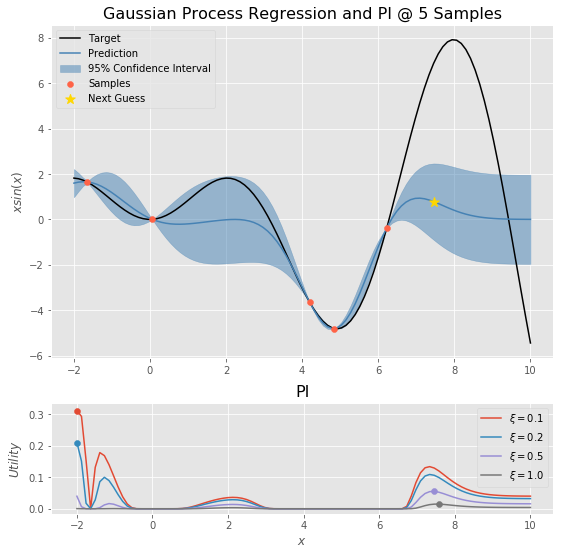

In [9]:
plot_gp_pi(gp, x, y)

Expected Improvement (EI)

In [10]:
def calc_ei(mu, std, y_max, xi):
    z = (mu - y_max - xi)/std.reshape(-1,1)
    return (mu - y_max - xi) * norm.cdf(z) + std.reshape(-1,1) * norm.pdf(z)

def plot_gp_ei(gp, x, y):
    x_sample, y_sample = gp.X_train_, gp.y_train_
    
    plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, std = gp.predict(x, return_std=True)
    axis.plot(x, y, color='black', label='Target')
    axis.plot(x, mu, color='steelblue', label='Prediction')
    axis.fill_between(x.ravel(), mu.ravel()-1.96*std, mu.ravel()+1.96*std, color='steelblue', alpha=0.5, label='95% Confidence Interval')
    axis.scatter(x_sample, y_sample, color='tomato', label='Samples', zorder=15)
    axis.set_ylabel('$xsin(x)$')
    axis.set_title('Gaussian Process Regression and EI @ 5 Samples', fontsize=16)
    
    y_max = y_sample.max()
    for xi in [0.1, 0.2, 0.5, 1.0]:
        util = calc_ei(mu, std, y_max, xi)
        acq.plot(x, util, label='$\\xi=%0.1f$' % xi)
        acq.scatter(x[util.argmax()], util.max())
        if xi==0.5:
            axis.scatter(x[util.argmax()], mu[util.argmax()], marker='*', s=100, lw=1, color='gold', zorder=20, label='Next Guess')
    acq.set_title('EI', fontsize=16)
    acq.set_xlabel('$x$')
    acq.set_ylabel('$Utility$')
    acq.legend(loc='best')
    axis.legend(loc='best')
    plt.show()

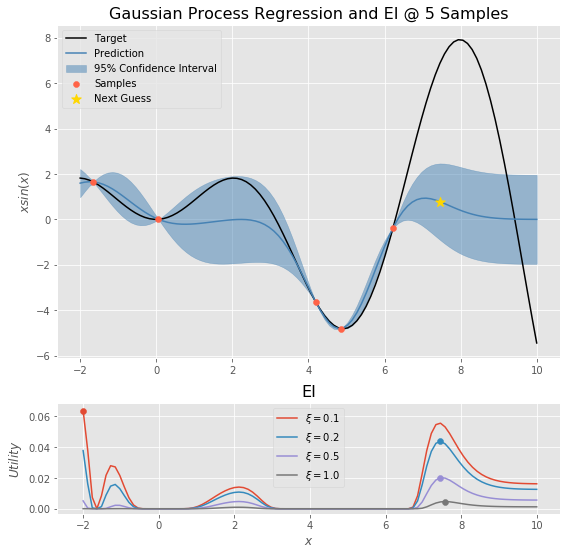

In [11]:
plot_gp_ei(gp, x, y)